The workflow will involve
- [x] Reading in the csv with all the scripts and the events demarcated, generated by Paxton on the cluster
- [x] Selecting just the first script
- [x] Cleaning up the script formatting
- [x] Creating a dataframe where each row is an event segment
- [x] Identifying all the unique characters in each event segment (new column)
- [x] Saving the number of unique characters in each event segment (new column)
- [x] Getting average word embedding for each segment, calculated from each individual word (50 dimensional vector) (new column)
- [x] Getting correlation across word embeddings for all words in a segment (new colum)
- [x] Extracting average sentiment of words in each segment (new column)

### Loading relevant libraries

In [1]:
import os
import requests as req
import seaborn as sns
import hypertools as hyp
import pandas as pd
import numpy as np
import html2text
import markdown
from bs4 import BeautifulSoup
import re
from num2words import num2words
from scipy.spatial.distance import cdist, pdist, squareform
import nltk

from nltk.corpus import stopwords as sw
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
import csv
import sys
csv.field_size_limit(sys.maxsize)

131072

In [3]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

### Reading in csv containing scripts and event boundaries

In [4]:
root_dir = '/Users/vassiki/Desktop/narrative_complexity/data/'
fn = 'first2_with_times.csv'
df = pd.read_csv(os.path.join(root_dir, fn))

### Select and format script by url

In [5]:
def wipe_formatting(script, rehtml=False):
    parser = html2text.HTML2Text()
    parser.wrap_links = True
    parser.skip_internal_links = True
    parser.inline_links = True
    parser.ignore_anchors = True
    parser.ignore_images = True
    parser.ignore_emphasis = True
    parser.ignore_links = True
    text = parser.handle(script)
    text = text.strip(' \t\n\r')
    if rehtml:
        text = text.replace('\n', '<br/>')
        text = text.replace('\\', '')
    md = markdown.markdown(text)
    soup=BeautifulSoup(md,'html5lib')
    soup=soup.get_text()
    soup = soup.replace('\n', ' ')
    return soup

In [6]:
def load_data(filepath, fileid):
    data_dir = os.path.dirname(filepath)
    
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    if not os.path.exists(filepath):
        print('downloading data...')
        dl(fileid, filepath)
        
    print('loading data...')
    data = pd.read_csv(filepath)
    return data.dropna(subset=['script'])

In [7]:
def cleanup_text(transcript):
    #lower_nopunc = re.sub("[^\w\s.]+", '', transcript.lower())    # remove all punctuation except periods (delimiters)
    lower_nopunc = re.sub("[^\w\s.]+", '', transcript)
    no_digit = re.sub(r"(\d+)", lambda x: num2words(int(x.group(0))), lower_nopunc)    # convert digits to words
    spaced = ' '.join(no_digit.replace(',', ' ').split())    # deal with inconsistent whitespace
    return spaced

In [8]:
def get_windows(transcript, wsize=50):
    cleaned = cleanup_text(wipe_formatting(transcript))
    text_list = cleaned.split('.')
    video_w = []
    
    for ix, sentence in enumerate(text_list):
        video_w.append(' '.join(text_list[ix:ix+wsize]))
        
    return video_w

In [9]:
def get_event_segments(df, row_index):
    vals = df[df.index == row_index]['event onsets/offsets'][row_index].split(', ')
    nums = [int(re.findall(r'\d+', v)[0])  for v in vals]
    return [(nums[n], nums[n+1]+1) for n in range(0,len(nums)-1,2)]    

In [10]:
def extract_script_info(url, df):
    row_index = df[df.url == url].index[0]
    # get some useful info using the index
    title = df.loc[row_index, 'title']
    genres = df.loc[row_index, 'genres']
    events = df.loc[row_index, 'n_events']
    
    # getting most important components
    event_identifiers = get_event_segments(df, row_index)
    script = df.loc[row_index, 'script']
    
    script_windows = get_windows(script, wsize=50)
    
    script_df = pd.DataFrame()
    
    event_words = []
    num_sentences = []
    for idx, event in enumerate(event_identifiers):
        event_content = script_windows[event[0]:event[1]]
        event_words.append([event_content])
        num_sentences.append(len(event_content))
    
    events_df = pd.DataFrame(event_words, columns={'content'})
    events_df['title'] = title
    events_df['intervals'] = event_identifiers
    events_df['genre'] = genres
    events_df['num_events'] = events
    events_df['num_sentences'] = num_sentences
    
    return events_df

In [415]:
# let's get the events dataframe for the first script
url = 'http://www.imsdb.com/scripts/10-Things-I-Hate-About-You.html'
events_df = extract_script_info(url, df)

### Annotating characters in each row

In [12]:
def tag_entities(word_window):
    characters = []
    doc = nlp(word_window)
    annotations = [(X.text, X.label_) for X in doc.ents]
    return annotations

In [13]:
def extract_characters(annotations):    
    return [ann[0] for ann in annotations if ann[1] == 'PERSON']

In [14]:
def characters_over_script(words):
    df = pd.DataFrame()
    for idx, window in enumerate(words):
        annotations = tag_entities(window)
        characters = extract_characters(annotations)
        characters_lower = [c.lower() for c in characters]
        res = pd.DataFrame.from_records([characters_lower])
        df = pd.concat([df, res], ignore_index=False)
    return df

In [62]:
def get_unique_characters(character_df):
    characters = []
    for col in list(character_df.columns):

        col_characters = list(character_df[col].unique())

        characters.extend([c for c in col_characters if c not in characters])
    cleanedList = [x for x in characters if str(x) != 'nan']
    cleanedList.sort()
    return cleanedList

In [16]:
def count_character_occurence(character_df):
    characters = get_unique_characters(character_df)
    # for each column in transposed matrix, count the number of occurences for each character
    # end up with a dictionary that has character names as column names and counts for each column as a row
    # 1758 by 201
    flip_df = character_df.transpose()
    flip_df.columns = np.arange(flip_df.shape[1])
    char_dict = {}
    for char in characters:
        char_counts_per_col = np.zeros(flip_df.shape[1])
        for idx in list(flip_df.columns):
            col_count = flip_df[idx].str.contains(char).sum()
            char_counts_per_col[idx] = col_count
        char_dict[char] = char_counts_per_col
    return char_dict    

In [156]:
def get_character_counts_per_event(edf):
    
    edf['characters'] = ''
    for event_id in range(edf.shape[0]):
        event_char_df = characters_over_script(edf.loc[event_id, 'content'])
        event_char_count = count_character_occurence(event_char_df)
        event_char_count_sum = {c:event_char_count[c].sum() for c in event_char_count}
        num_chars = len(event_char_count_sum.keys())
        edf.loc[event_id, 'num_characters'] = num_chars
        edf.loc[event_id, 'characters'] = [event_char_count_sum]
    return edf        

In [416]:
# this will take around 5 minutes to run
events_char_df = get_character_counts_per_event(events_df)

In [366]:
def plot_one_event(row):
    # ToDo: Make the dictionary keys alphabetic
    index = row.index[0]
    print(index)
    char_df = characters_over_script(row.loc[index, 'content'])
    cd = count_character_occurence(char_df)
    cd_df = pd.DataFrame(cd)
    cd_df = cd_df.rename(index={i: "Window {0}".format(i) for i in cd_df.index})
    ax = plt.axes()
    sns.heatmap(cd_df)
    plt.savefig('event_{}.png'.format(index), bbox_inches = "tight")

In [129]:
def plot_all_events(events_char_df, threshold = 3):
    d = pd.DataFrame()

    for row_idx in range(events_char_df.shape[0]):
        row_chars = list(events_char_df.loc[row_idx, 'characters'].keys())
        res = pd.DataFrame.from_records([row_chars])
        d = pd.concat([d, res], ignore_index=False)
    cd = count_character_occurence(d)
    cd_df = pd.DataFrame(cd)
    cd_df = cd_df.rename(index={i: "Event {0}".format(i) for i in cd_df.index})
    above_thresh = cd_df[cd_df.columns[(cd_df>threshold).any()]]
    print(above_thresh.shape)
    ax = plt.axes()
    sns.heatmap(above_thresh)
    ax.set_title('Characters appearing more than {0} times within an event, Total {1}'.format(threshold,above_thresh.shape[1]))
    plt.savefig('character_mentions_{0}.png'.format(threshold), bbox_inches = "tight")

In [147]:
def plot_recurrent_characters(events_char_df, threshold = 20):
    d = pd.DataFrame()

    for row_idx in range(events_char_df.shape[0]):
        row_chars = list(events_char_df.loc[row_idx, 'characters'].keys())
        res = pd.DataFrame.from_records([row_chars])
        d = pd.concat([d, res], ignore_index=False)
    cd = count_character_occurence(d)
    cd_df = pd.DataFrame(cd)
    cd_df = cd_df.rename(index={i: "Event {0}".format(i) for i in cd_df.index})
    above_thresh = cd_df[cd_df.columns[cd_df.sum()>threshold]]
    print(above_thresh.shape)
    ax = plt.axes()    
    sns.heatmap(above_thresh)
    ax.set_title('Characters appearing in more than {0} events, Total {1}'.format(threshold,above_thresh.shape[1]))
    plt.savefig('character_recurrence_{0}.png'.format(threshold), bbox_inches = "tight")

(49, 14)


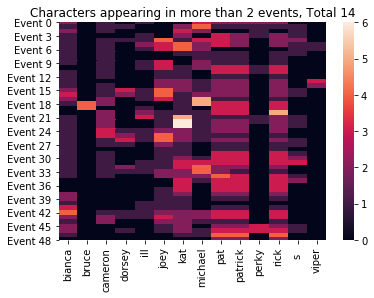

In [136]:
plot_all_events(events_char_df, 2)

(49, 42)


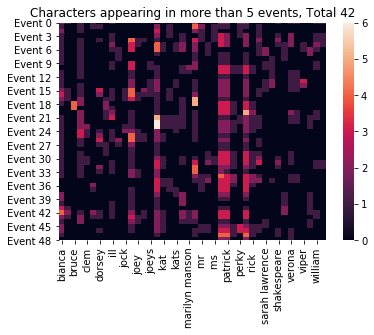

In [151]:
plot_recurrent_characters(events_char_df, threshold = 5)

### Word embeddings for events

In [ ]:
tokens = nltk.word_tokenize(script_one)
cleaned_tokens = [t.lower() for t in tokens if len(t) > 2]

In [160]:
glove_embeddings = '/Users/vassiki/Downloads/glove.6B/glove.6B.50d.txt'

In [161]:
def load_embeddings(embedding_file):
    emb = {}
    with open(embedding_file, 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        for row in spamreader:
            emb[''.join(row[0])] = ' '.join(row[1:])
    return emb

In [162]:
# this might take a couple of minutes!
embedding = load_embeddings(glove_embeddings)

In [420]:
def embedding_extractor(tokens, embedding):
    weights = []
    for tok in tokens:
        if tok in embedding.keys():
            weights.append(np.array([float(val) for val in embedding[tok].split(' ')]))
    return np.array(weights)

In [436]:
def get_semantic_weights(edf):
    for i in range(edf.shape[0]):
        content = edf.loc[i,'content']
        flat_content= ' '.join(content)
        stop = sw.words('english')
        tokens = nltk.word_tokenize(flat_content)
        cleaned_tokens = [t.lower() for t in tokens if len(t) > 2 and t not in stop]
        tok_emb_arr = embedding_extractor(cleaned_tokens, embedding)
        mean_emb_val = np.mean(np.mean(tok_emb_arr, axis=0))
        corr = np.corrcoef(tok_emb_arr)
        mean_corr = np.mean(corr, axis=0)
        mean_corr_ev = np.round(np.mean(mean_corr),3)    
        
        edf.loc[i, 'mean_emb'] = mean_emb_val
        edf.loc[i, 'mean_emb_vec'] = str(np.mean(tok_emb_arr, axis=0))
        edf.loc[i, 'corr_across_tokens'] = mean_corr_ev

    return edf

In [438]:
e = get_semantic_weights(events_char_df)

### Extracting sentiments for each event

In [478]:
#sentences
def prepare_sentence_tokens(edf, row_index):
    content = [ev.split('  ') for ev in edf.loc[row_index,'content']]
    flat_content = sum(content, [])
    content_str = '. '.join(flat_content)
    tokens = nltk.sent_tokenize(content_str)
    return tokens

In [458]:
def sentiment_extractor(tokens):
    df = pd.DataFrame()
    for w in tokens:
        sid = SentimentIntensityAnalyzer()
        ss = sid.polarity_scores(w)
        res = pd.DataFrame.from_records([ss])
        res['word'] = w
        df = pd.concat([df, res], ignore_index=False)
    return df

In [475]:
def sentiment_per_event(edf):
    for row in range(edf.shape[0]):
        #content = [ev.split('  ') for ev in edf.loc[row,'content']]
        #flat_content = sum(content, [])
        #content_str = '. '.join(flat_content)
        #tokens = nltk.sent_tokenize(content_str)
        tokens = prepare_sentence_tokens(edf, row)
        sentiments = sentiment_extractor(tokens)
        
        edf.loc[row, 'sent_positive'] = sentiments['pos'].mean()
        edf.loc[row, 'sent_negative'] = sentiments['neg'].mean()
        edf.loc[row, 'sent_neutral'] = sentiments['neu'].mean()
        edf.loc[row, 'compound'] = sentiments['compound'].mean()
    return edf

In [476]:
sec_df = sentiment_per_event(e[:2])

/Users/vassiki/anaconda2/envs/trial_python3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/vassiki/anaconda2/envs/trial_python3/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
